In [33]:
import ROOT as r
r.EnableImplicitMT()

from xgboost import XGBClassifier
import numpy as np

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

import hist
from matplotlib import pyplot as plt
import mplhep as hep
hep.style.use(hep.style.CMS)

In [34]:
def load_data(signal_filename, background_filename):
    data_sig = r.RDataFrame("Events", signal_filename)
    data_bkg = r.RDataFrame("Events", background_filename)
 
    data_sig = data_sig.Filter("passCut9").AsNumpy()
    data_bkg = data_bkg.Filter("passCut9").AsNumpy()

    variables = ["VBSjet1pt", "VBSjet1eta", "VBSjet1phi", "VBSjet2pt", "VBSjet2eta", "VBSjet2phi", "VBSMjj", "VBSdetajj", "weight"]

    x_sig = np.vstack([data_sig[var] for var in variables[:-1]]).T
    x_bkg = np.vstack([data_bkg[var] for var in variables[:-1]]).T
    x = np.vstack([x_sig, x_bkg])
 
    num_sig = x_sig.shape[0]
    num_bkg = x_bkg.shape[0]
    y = np.hstack([np.ones(num_sig), np.zeros(num_bkg)])
 
    w = np.hstack([data_sig["weight"], data_bkg["weight"]])
    
    return x, y, w

In [3]:
x, y, w = load_data("/data/userdata/aaarora/output/run2/sig.root", "/data/userdata/aaarora/output/run2/bkg.root")

In [179]:
params = {
 "model_params": {
    "n_estimators": 200,
    "max_depth": 3,
    "learning_rate": 0.1,
    "lambda": 1.0,
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "tree_method": "exact",
    "verbosity": 1,
    "validate_parameters": True,
    "nthread": 64,
  }
}
bdt = XGBClassifier(**params["model_params"],)

In [180]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)
bdt.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])

[0]	validation_0-logloss:0.62402	validation_1-logloss:0.62514
[1]	validation_0-logloss:0.57860	validation_1-logloss:0.57950
[2]	validation_0-logloss:0.54005	validation_1-logloss:0.54099
[3]	validation_0-logloss:0.50765	validation_1-logloss:0.50854
[4]	validation_0-logloss:0.48036	validation_1-logloss:0.48129
[5]	validation_0-logloss:0.45766	validation_1-logloss:0.45855
[6]	validation_0-logloss:0.43748	validation_1-logloss:0.43850
[7]	validation_0-logloss:0.42078	validation_1-logloss:0.42179


[8]	validation_0-logloss:0.40640	validation_1-logloss:0.40740
[9]	validation_0-logloss:0.39304	validation_1-logloss:0.39404
[10]	validation_0-logloss:0.38142	validation_1-logloss:0.38267
[11]	validation_0-logloss:0.37122	validation_1-logloss:0.37255
[12]	validation_0-logloss:0.36291	validation_1-logloss:0.36416
[13]	validation_0-logloss:0.35542	validation_1-logloss:0.35677
[14]	validation_0-logloss:0.34831	validation_1-logloss:0.34978
[15]	validation_0-logloss:0.34270	validation_1-logloss:0.34417
[16]	validation_0-logloss:0.33713	validation_1-logloss:0.33871
[17]	validation_0-logloss:0.33263	validation_1-logloss:0.33431
[18]	validation_0-logloss:0.32818	validation_1-logloss:0.33001
[19]	validation_0-logloss:0.32425	validation_1-logloss:0.32618
[20]	validation_0-logloss:0.32119	validation_1-logloss:0.32311
[21]	validation_0-logloss:0.31805	validation_1-logloss:0.32006
[22]	validation_0-logloss:0.31516	validation_1-logloss:0.31741
[23]	validation_0-logloss:0.31295	validation_1-logloss:0.

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=1.0,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, nthread=64, ...)

In [175]:
y_pred = bdt.predict_proba(X_test)[:, 1]

In [176]:
coff = bdt.score(X_test, y_test)
print(f"Sensitivity: {coff}")

Sensitivity: 0.8838107622289364


In [160]:
false_positive_rate, true_positive_rate, _ = roc_curve(y_test, y_pred)
score = auc(false_positive_rate, true_positive_rate)

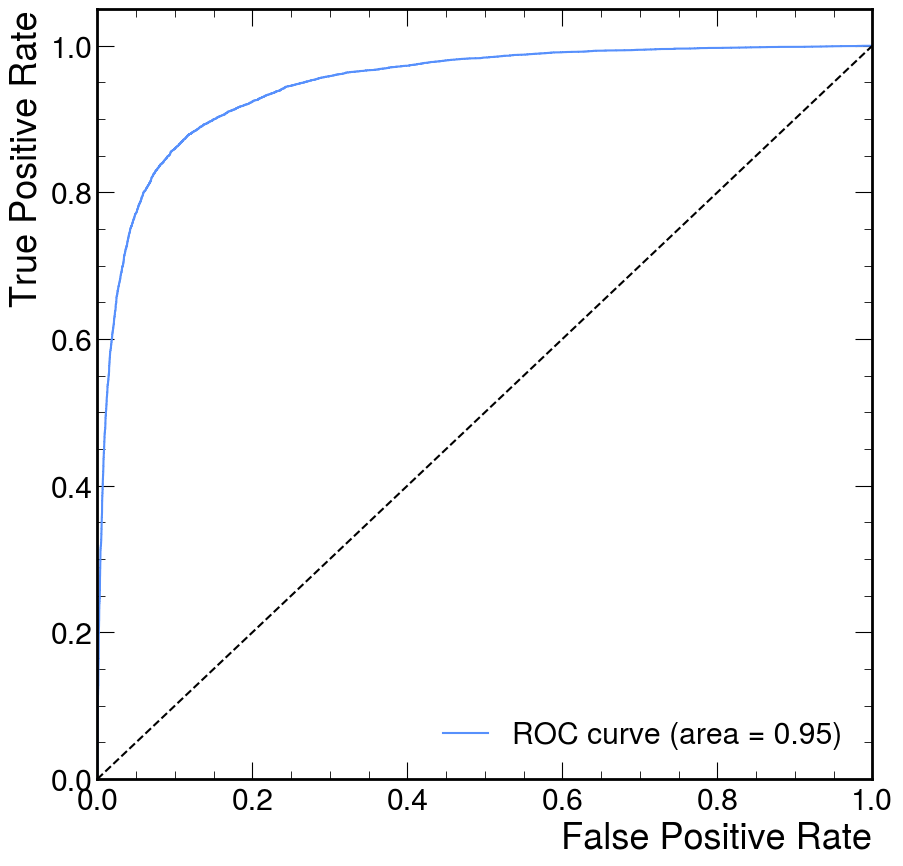

In [161]:
fig, ax = plt.subplots()
ax.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.2f)' % score)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()

In [143]:
r.TMVA.Experimental.SaveXGBoost(bdt, "VBSBDT", "BDT_Weights.root", num_inputs=x.shape[1])

# Validation

In [144]:
bdt = r.TMVA.Experimental.RBDT("VBSBDT", "/home/users/aaarora/phys/analysis/vbs-1lep/training/BDT/BDT_Weights.root")

Text(0, 1, 'Density')

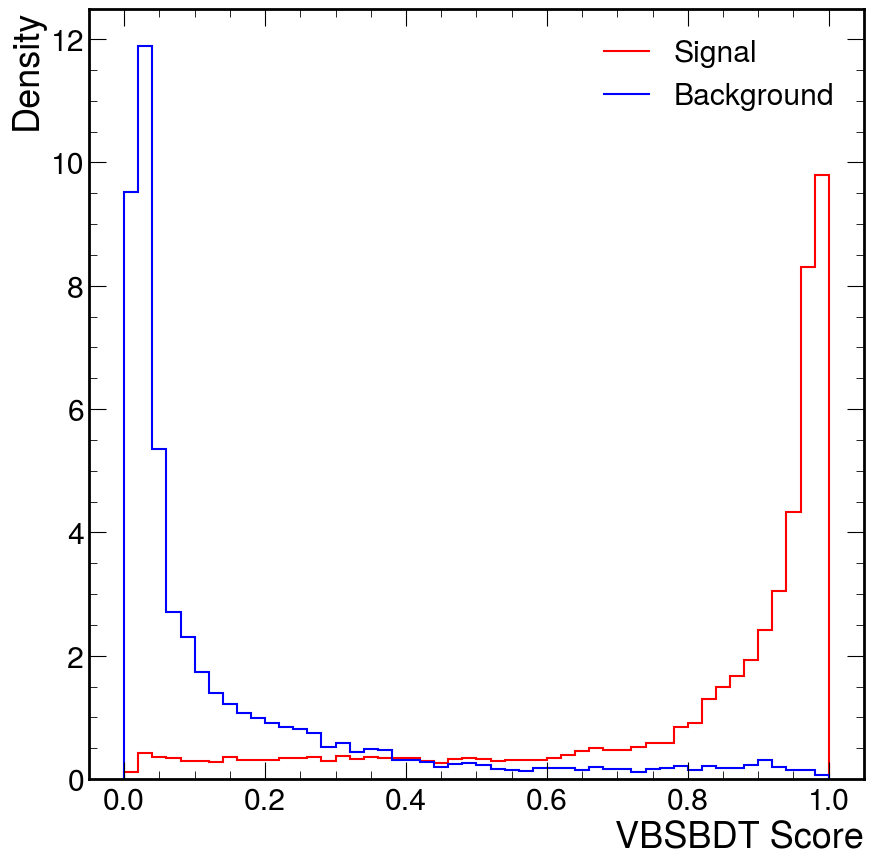

In [147]:
h1 = hist.Hist.new.Reg(50, 0, 1, name="SIG", label="SIG").Double()
h1.fill(bdt.Compute(x[y==1]).flatten(), weight=w[y==1])

h2 = hist.Hist.new.Reg(50, 0, 1, name="BKG", label="BKG").Double()
h2.fill(bdt.Compute(x[y==0]).flatten(), weight=w[y==0])

fig, ax = plt.subplots()
hep.histplot(h1, ax=ax, label="Signal", color="red", density=True)
hep.histplot(h2, ax=ax, label="Background", color="blue", density=True)

ax.legend()
ax.set_xlabel("VBSBDT Score")
ax.set_ylabel("Density")